# **Introduction**

**About Data** 
The data consist of **8 classes**. Each class represents a **micro-organism**. These classes are: 

1. **Amoeba**
2. **Euglena**
3. **Hydra**
4. **Paramecium**
5. **Rod bacteria**
6. **Spherical Bacteria**
7. **Spiral Bacteria**
8. **Yeast**

Most of these classes represent a **microorganism**, which is a **bacteria**. As a **total number of images** is **very less** to train a **model from scratch**. We will be using **transfer learning** approach to **train the model**.

# **Imports**

Below are **all the imports** used in the **notebook**.

In [2]:
# Common
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf



# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model 
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Callbacks 
from keras.callbacks import EarlyStopping as ES, ModelCheckpoint as MC

# Pre-Trained Model
from tensorflow.keras.applications import ResNet50V2, ResNet50, InceptionV3, Xception

# **Enable effective use of GPU**

In [3]:
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1' # This will allow automatic expression to take place.

This is the process, which converts the **model weights** during the training into **16FP and 32FP**, while **loading and saving the weights**. This allow for **better utilization of the GPU memory**.

# **Data Information**

Before loading the data into memory, let's have a look at the **data distribution**. More specifically, at the **class distribution**.

In [4]:
#  Specify root path
root_path = r"E:\bacteria__prediction\Micro_Organism"

# Get class names
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

# Calculate class distribution
class_dis = [len(os.listdir(root_path + name)) for name in class_names]

# Show
print(f"Number of Classes : {n_classes}\nClass names : {class_names}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'E:\\bacteria__prediction\\Micro_OrganismAmoeba'

Let's look at how each **class is distributed in the data**.

In [4]:
# Pie plot
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

All the **classes are not equally distributed**. This is **not a good sign**, because this can make the **model biased towards the highly populated class**. Let's look at this in terms of the **actual numbers**.

In [5]:
# Bar Plot
fig = px.bar(x=class_names, y=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

**On average**, classes are **equally distributed**, but **two classes** are **highly populated** as compared to the **rest of the classes**.

---
One way to **solve this problem** is to **fix the data set**. But for now, we **can continue** with **this data set**. But it will be a **good idea to fix the data set** and **make all the classes equally distributed**.

# **Data Loading**

OK so now, we have the knowledge of the **class distribution and the data distribution**. But now let's **load the data** and **visualize it**, in order to **understand the actual problem**. For loading the data, I'm going to use **image data generator** from **Keras**.

In [6]:
# Initialize generator
gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    brightness_range=[0.3,0.8],
    validation_split=0.1
)

Here, I have applied **few augmentations** on the data set, such as **random rotation**, **horizontal flip**, **brightness range**, and at last, as there is **no provided validation data set** for evaluationg the model, We will use **10%** of the whole data as **validation data**.

In [7]:
# Load Data
train_ds = gen.flow_from_directory(
    root_path,
    batch_size=128, # For better utilization of GPU, I have kept the batch size a little bit
    shuffle=True,
    class_mode='binary',
    target_size=(256,256), # This image size is generally sufficient for better image classifications.
    subset='training'
)

valid_ds = gen.flow_from_directory(
    root_path,
    batch_size=64, # For faster inference, the batch size here is small.
    shuffle=True,
    class_mode='binary',
    target_size=(256,256), # This image size is generally sufficient for better image classifications.
    subset='validation'
)

Found 714 images belonging to 8 classes.
Found 75 images belonging to 8 classes.


# **Data Visulization**

For **better understanding the actual image classification problem**, we need to have a **look at the images**. For this, we will **create a function** that will also help us at the **inference time**.

In [8]:
def show_images(data, GRID=[2,6], model=None, size=(25,10)):
    
    # The plotting configurations
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=size)
    
    # Data for visualization
    images, labels = next(iter(data)) # This process can take a little time because of the large batch size
    
    # Iterate through the subplots.
    for i in range(1, n_images+1):
        
        # Select a random data
        id = np.random.randint(len(images)) # This is a dynamic function because for validation data and training data, the length of total images is different.
        image, label = images[id], class_names[int(labels[id])]
        
        # Plot the sub plot
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        plt.axis('off')
        
        # If model is available make predictions.
        if model is not None:
            pred = class_names[np.argmax(model.predict(image[np.newaxis,...]))]
            title = f"Class : {label}\nPred : {pred}"
        else:
            title = f"Class : {label}"
        
        plt.title(title)
    plt.show()

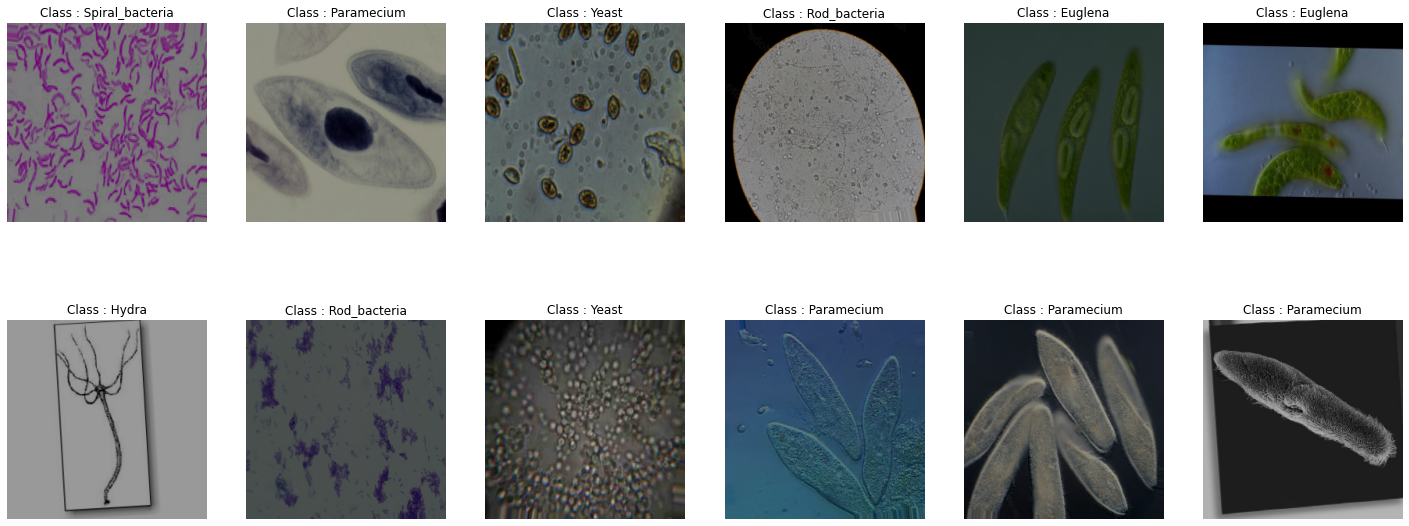

In [9]:
show_images(data=train_ds)

This can be a **tough task** for the **model** because of the **wide variety of geometric shapes and color differences**. But this **wide variety** also makes it **easy to classify each of the bacteria individually**.

# **Model**

In [10]:
# Give you a model, a name
name = "inception-v3"

# Base model
base = InceptionV3(input_shape=(256,256,3), include_top=False)
base.trainable = False

# Model Architecture
model = Sequential([
    base, GAP(),
    Dense(256, kernel_initializer='he_normal', activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
])

# Callbacks
cbs = [ES(patience=3, restore_best_weights=True), MC(name + ".h5", save_best_only=True)]

# Compile Model
opt = tf.keras.optimizers.Adam(learning_rate=1e-3) # Higher than the default learning rate
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Training
history = model.fit(train_ds, validation_data=valid_ds, epochs=50, callbacks=cbs)

2022-11-04 13:21:27.037946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 13:21:27.041605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 13:21:27.042348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 13:21:27.043530: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 4s 0us/step


2022-11-04 13:21:39.822901: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-11-04 13:21:48.007710: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


6/6 [==============================] - 36s 4s/step - loss: 2.1917 - accuracy: 0.2395 - val_loss: 1.6268 - val_accuracy: 0.4533
Epoch 2/50
6/6 [==============================] - 21s 4s/step - loss: 1.5629 - accuracy: 0.4496 - val_loss: 1.3123 - val_accuracy: 0.5867
Epoch 3/50
6/6 [==============================] - 21s 4s/step - loss: 1.2125 - accuracy: 0.6022 - val_loss: 1.2492 - val_accuracy: 0.5867
Epoch 4/50
6/6 [==============================] - 20s 3s/step - loss: 1.0239 - accuracy: 0.6429 - val_loss: 1.1408 - val_accuracy: 0.6133
Epoch 5/50
6/6 [==============================] - 20s 3s/step - loss: 0.9304 - accuracy: 0.6821 - val_loss: 1.1389 - val_accuracy: 0.6667
Epoch 6/50
6/6 [==============================] - 20s 4s/step - loss: 0.8063 - accuracy: 0.7507 - val_loss: 1.0463 - val_accuracy: 0.6667
Epoch 7/50
6/6 [==============================] - 21s 3s/step - loss: 0.7518 - accuracy: 0.7437 - val_loss: 1.0099 - val_accuracy: 0.6800
Epoch 8/50
6/6 [=============================

I have already tried out other models and other variations, such as changing the dropout rate, applying regularizations, changing the total number of units, using different pre-trained model, but this was the most robust out of them. The reason behind low validation performance is because of the highly less number of images available for training. 

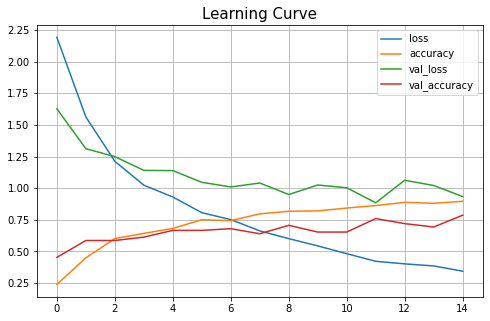

In [11]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title("Learning Curve", fontsize=15)
plt.grid()
plt.show()

The curves are **not perfect**, but they are **still satisfying**. Let's have a look at the **model predictions.**

# **Model predictions**

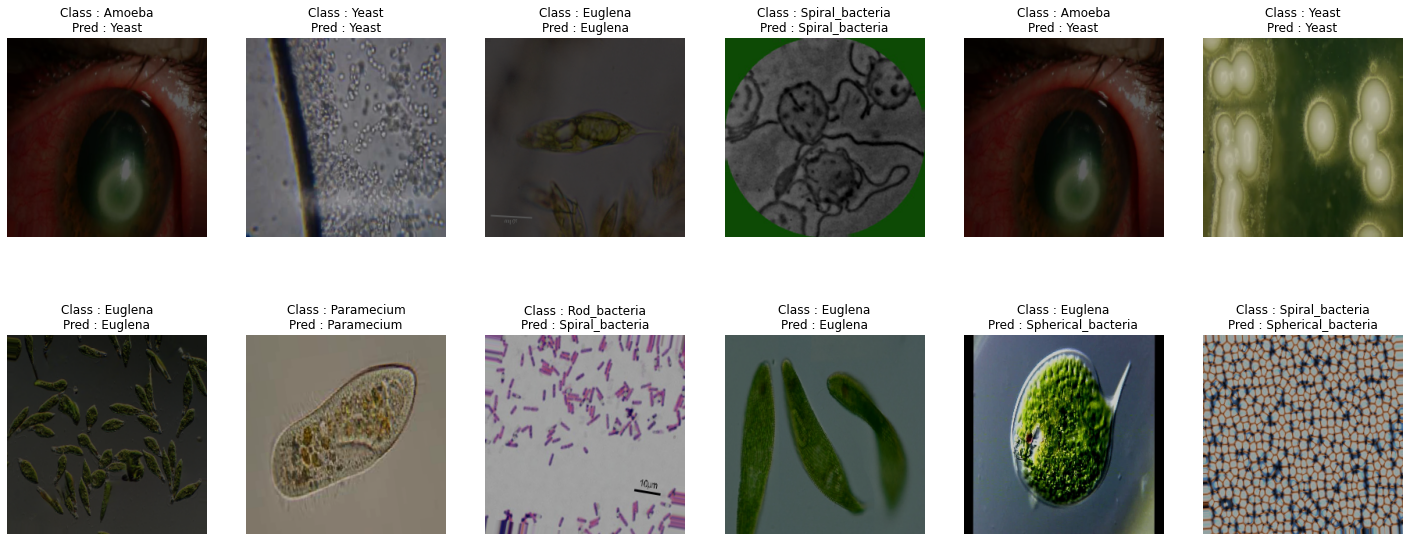

In [12]:
show_images(data=valid_ds, model=model)

Despite of the **low validation accuracy** majority of all the classes are **correctly classified**. I think this **low accuracy** is **because of the low number of training images**. But if I'm wrong, please let me know in the comments. 

Thank you.

---
**Deep nets**